# Proyecto - Estudio del efecto de la profundidad y conexiones residuales en redes neuronales
### EL4106 Inteligencia Computacional

Profesor de Cátedra: Pablo Estévez<br>
Profesor Auxiliar: Pablo Cornejo<br>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import time
import numpy as np
import seaborn as sns
import pandas as pd
!pip install umap
import umap

  Preparing metadata (setup.py) ... done
  Created wheel for umap: filename=umap-0.1.1-py3-none-any.whl size=3542 sha256=5d6cec8b394744a5eee2cc4ea78124f9c0486fce28be9e3f8933766da8814477
  Stored in directory: /root/.cache/pip/wheels/15/f1/28/53dcf7a309118ed35d810a5f9cb995217800f3f269ab5771cb
Successfully built umap


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).




##Datasets


In [ ]:
# Crear datasets separados para entrenamiento y validación
full_cifar10 = torchvision.datasets.CIFAR10(
    root="./cifar10",
    train=True,
    download=True,
)

# Definir transformaciones por separado
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.Lambda(lambda x: x + torch.randn_like(x) * 0.05),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
])

val_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
])

# Aplicar las transformaciones al crear los datasets
train_cifar10 = torchvision.datasets.CIFAR10(
    root="./cifar10",
    train=True,
    download=False,
    transform=train_transform
)

val_cifar10 = torchvision.datasets.CIFAR10(
    root="./cifar10",
    train=True,
    download=False,
    transform=val_transform
)

# Dividir los datasets
train_cifar10, _ = torch.utils.data.random_split(train_cifar10, [45000, 5000], generator=torch.Generator().manual_seed(42))
_, val_cifar10 = torch.utils.data.random_split(val_cifar10, [45000, 5000], generator=torch.Generator().manual_seed(42))


100%|██████████| 170498071/170498071 [00:01<00:00, 91570195.87it/s]


Extracting ./cifar10/cifar-10-python.tar.gz to ./cifar10


## Codigo para hacer la carga de datasets del drive

### Tema: Regularización
La **regularización** es un conjunto de técnicas utilizadas en machine learning y deep learning para prevenir el **sobreajuste** (overfitting). El sobreajuste ocurre cuando un modelo aprende demasiado bien los detalles y ruido de los datos de entrenamiento, lo que resulta en un mal rendimiento cuando se evalúa en nuevos datos no vistos (conjunto de validación o test). La regularización ayuda a mejorar la **capacidad de generalización** del modelo, es decir, su capacidad para funcionar bien en datos no vistos.

### Tipos comunes de regularización:

1. **L2 Regularization (Weight Decay)**:
   - **Descripción**: Penaliza los pesos grandes al agregar un término a la función de pérdida que aumenta con el tamaño de los pesos.
   - **Fórmula**: El término de penalización en la función de pérdida es:
$ L(\theta) = L_0 + \lambda \sum_{i=1}^{n} \theta_i^2 $
     Donde:
     - $ L_0 $ es la pérdida original (por ejemplo, la entropía cruzada).
     - $ \theta_i $ son los pesos de la red.
     - $ \lambda $ es el hiperparámetro que controla la magnitud de la penalización (también llamado **weight decay**).
   - **Efecto**: Evita que los pesos crezcan demasiado, lo que podría hacer que el modelo sea demasiado dependiente de características particulares de los datos de entrenamiento.

2. **L1 Regularization**:
   - **Descripción**: Similar a L2, pero en lugar de penalizar los pesos grandes con un término cuadrático, penaliza la suma de los valores absolutos de los pesos.
   - **Fórmula**:
     $$
  L(\theta) = L_0 + \lambda \sum_{i=1}^{n} |\theta_i|
     $$
   - **Efecto**: Alienta la **sparsity** (la mayoría de los pesos se vuelven cero), lo que puede resultar en modelos más simples.

3. **Dropout**:
   - **Descripción**: Durante el entrenamiento, **desactiva aleatoriamente** una fracción de las neuronas en cada capa en cada paso de entrenamiento. Esto evita que el modelo se vuelva demasiado dependiente de cualquier neurona individual.
   - **Efecto**: Dropout actúa como un ensamble implícito de varias redes neuronales, entrenando diferentes subredes.

4. **Early Stopping**:
   - **Descripción**: Se detiene el entrenamiento del modelo cuando la precisión en el conjunto de validación deja de mejorar después de un cierto número de épocas.
   - **Efecto**: Evita que el modelo continúe ajustándose demasiado a los datos de entrenamiento.

5. **Data Augmentation**:
   - **Descripción**: **Aumentar artificialmente** el conjunto de datos al aplicar transformaciones aleatorias (rotaciones, escalado, recortes, etc.) puede hacer que el modelo vea más variedad en los datos y evitar el sobreajuste.
   - **Efecto**: Hace que el modelo aprenda características más generales y robustas.

6. **Batch Normalization**:
   - **Descripción**: Normaliza las activaciones de cada capa durante el entrenamiento, asegurando que la distribución de las activaciones permanezca estable. También tiene un efecto regularizador.
   - **Efecto**: Ayuda a estabilizar y acelerar el entrenamiento, además de reducir el sobreajuste.

### Aspectos a considerar al aplicar regularización:

1. **Hiperparámetros**:
   - El valor del coeficiente de regularización $\lambda$ en L2/L1 es crucial. Si es muy bajo, no se sentirá el efecto de la regularización, y si es muy alto, puede hacer que el modelo sea demasiado conservador.
   - Para **dropout**, la probabilidad de "dropout" $p$ debe seleccionarse cuidadosamente (valores comunes entre **0.3 y 0.5**).

2. **Balance entre regularización y ajuste**:
   - La regularización busca reducir el sobreajuste, pero demasiada regularización puede causar subajuste. Es importante encontrar un equilibrio.

3. **Evaluación con conjunto de validación**:
   - Siempre evalúa el impacto de la regularización en un conjunto de validación. Si la precisión de entrenamiento es alta pero la de validación es baja, probablemente estés sobreajustando.

4. **Tamaño del modelo y datos**:
   - Modelos grandes entrenados en conjuntos de datos pequeños son más propensos al sobreajuste, por lo que necesitan más regularización.

### Ejemplo práctico:

Si estás entrenando una red neuronal profunda en CIFAR-10 y notas que el modelo tiene una alta precisión en el conjunto de entrenamiento pero baja en validación, es posible que esté ocurriendo sobreajuste. Podrías intentar:
- Agregar **L2 regularization** al optimizador ajustando el parámetro `weight_decay` (por ejemplo, **1e-4**).
- Aumentar el tamaño del conjunto de datos mediante **data augmentation** aplicando rotaciones, traslaciones o recortes aleatorios.

## Checkpoints

In [ ]:

checkpoint_dir = "/content/drive/MyDrive/checkpoints/"

# Crear el directorio si no existe
import os
os.makedirs(checkpoint_dir, exist_ok=True)


In [ ]:
def checkpoint(model, optimizer, epoch, filename):
    checkpoint_data = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }
    torch.save(checkpoint_data, os.path.join(checkpoint_dir, filename))

def resume(model, optimizer, filename):
    checkpoint_data = torch.load(os.path.join(checkpoint_dir, filename))
    model.load_state_dict(checkpoint_data['model_state_dict'])
    optimizer.load_state_dict(checkpoint_data['optimizer_state_dict'])
    return checkpoint_data['epoch']


##Red plana sin regularizacion en pytorch

In [ ]:
class RedPlana18CNN(nn.Module):
    def __init__(self):
        super(RedPlana18CNN, self).__init__()

        self.features = nn.Sequential(
            # Bloque Convolucional 1
            nn.Conv2d(3, 64, kernel_size=3, padding=1),    # Capa 1
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),   # Capa 2
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Bloque Convolucional 2
            nn.Conv2d(64, 128, kernel_size=3, padding=1),  # Capa 3
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1), # Capa 4
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Bloque Convolucional 3
            nn.Conv2d(128, 256, kernel_size=3, padding=1), # Capa 5
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1), # Capa 6
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1), # Capa 7
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Bloque Convolucional 4
            nn.Conv2d(256, 512, kernel_size=3, padding=1), # Capa 8
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1), # Capa 9
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1), # Capa 10
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Bloque Convolucional 5
            nn.Conv2d(512, 512, kernel_size=3, padding=1), # Capa 11
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1), # Capa 12
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1), # Capa 13
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512, 512),    # Capa 14
            nn.ReLU(inplace=True),
            nn.Linear(512, 256),    # Capa 15
            nn.ReLU(inplace=True),
            nn.Linear(256, 128),    # Capa 16
            nn.ReLU(inplace=True),
            nn.Linear(128, 64),     # Capa 17
            nn.ReLU(inplace=True),
            nn.Linear(64, 10),      # Capa 18
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


### Función de entrenamiento y visualización

In [ ]:
def show_curves(curves):
    fig, ax = plt.subplots(1, 2, figsize=(13, 5))
    fig.set_facecolor('white')

    epochs = np.arange(len(curves["val_loss"])) + 1

    ax[0].plot(epochs, curves['val_loss'], label='validation')
    ax[0].plot(epochs, curves['train_loss'], label='training')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].set_title('Loss evolution during training')
    ax[0].legend()

    ax[1].plot(epochs, curves['val_acc'], label='validation')
    ax[1].plot(epochs, curves['train_acc'], label='training')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_title('Accuracy evolution during training')
    ax[1].legend()

    plt.tight_layout()
    plt.savefig('training_curves.png')  # Guardar la figura
    plt.show()

In [ ]:
def train_step(x_batch, y_batch, model, optimizer, criterion, use_gpu):
    # Predicción
    y_predicted = model(x_batch)

    # Cálculo de loss
    loss = criterion(y_predicted, y_batch)

    # Actualización de parámetros
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return y_predicted, loss

def evaluate(val_loader, model, criterion, use_gpu):
    cumulative_loss = 0
    cumulative_predictions = 0
    data_count = 0

    model.eval()
    with torch.no_grad():
        for x_val, y_val in val_loader:
            if use_gpu:
                x_val = x_val.cuda()
                y_val = y_val.cuda()

            y_predicted = model(x_val)

            loss = criterion(y_predicted, y_val)

            class_prediction = torch.argmax(y_predicted, axis=1).long()

            cumulative_predictions += (y_val == class_prediction).sum().item()
            cumulative_loss += loss.item()
            data_count += y_val.shape[0]

    val_acc = cumulative_predictions / data_count
    val_loss = cumulative_loss / len(val_loader)

    return val_acc, val_loss


def train_model(
    model,
    train_dataset,
    val_dataset,
    epochs,
    max_iterations,
    criterion,
    batch_size,
    lr,
    n_evaluations_per_epoch,
    use_gpu=True,
    data_augmentation=False,
    resume_checkpoint=None
):

    original_transform = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
    ])

    if data_augmentation:
        train_dataset.dataset.transform = torchvision.transforms.Compose([
            original_transform,
            torchvision.transforms.RandomHorizontalFlip(),
            torchvision.transforms.Lambda(lambda x: x + torch.randn(3, 1, 1) * 0.05)
        ])

    else:
        train_dataset.dataset.transform = original_transform

    print(f"Using train transform: {train_dataset.dataset.transform}")
    print(f"Using validation transform: {val_dataset.dataset.transform}")

    if use_gpu:
        model.cuda()

    # Definición de dataloader
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=use_gpu)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64 , shuffle=False, pin_memory=use_gpu)

    # Optimizer: SGD with momentum
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)

    # Scheduler: Reduce el learning rate por un factor de 10 si el error no mejora después de 5 épocas (por ejemplo)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

    # Listas para guardar curvas de entrenamiento
    curves = {
        "train_acc": [],
        "val_acc": [],
        "train_loss": [],
        "val_loss": [],
    }

    t0 = time.perf_counter()

    iteration = 0

    n_batches = len(train_loader)

    # Reanudar desde un checkpoint si existe
    start_epoch = 0
    if resume_checkpoint is not None:
        start_epoch = resume(model, optimizer, resume_checkpoint)
        print(f"Reanudando desde la época {start_epoch}")

    # === Registro de hooks para capturar activaciones y gradientes ===
    activations = {}
    gradients = {}

    def save_activation(name):
        def hook(model, input, output):
            activations[name] = output.detach().cpu()
        return hook

    def save_gradient(name):
        def hook(grad):
            gradients[name] = grad.detach().cpu()
        return hook

    # Registrar hooks en todas las capas
    for name, module in model.named_modules():
        if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
            module.register_forward_hook(save_activation(name))
            if module.weight.requires_grad:
                module.weight.register_hook(save_gradient(name + '_weight'))
            if module.bias is not None and module.bias.requires_grad:
                module.bias.register_hook(save_gradient(name + '_bias'))

    for epoch in range(start_epoch, epochs):
        print(f"\rEpoch {epoch + 1}/{epochs}")
        cumulative_train_loss = 0
        cumulative_train_corrects = 0
        train_loss_count = 0
        train_acc_count = 0

        # === Limpiar gradientes y activaciones al inicio de cada época ===
        epoch_activations = {}
        epoch_gradients = {}

        # Entrenamiento del modelo
        model.train()
        for i, (x_batch, y_batch) in enumerate(train_loader):
            if use_gpu:
                x_batch = x_batch.cuda()
                y_batch = y_batch.cuda()

            y_predicted, loss = train_step(x_batch, y_batch, model, optimizer, criterion, use_gpu)

            cumulative_train_loss += loss.item()
            train_loss_count += 1
            train_acc_count += y_batch.shape[0]

            # Calculamos número de aciertos
            class_prediction = torch.argmax(y_predicted, axis=1).long()
            cumulative_train_corrects += (y_batch == class_prediction).sum().item()

            if (i % (n_batches // n_evaluations_per_epoch) == 0) and (i > 0):
                train_loss = cumulative_train_loss / train_loss_count
                train_acc = cumulative_train_corrects / train_acc_count

                print(f"Iteration {iteration} - Batch {i}/{len(train_loader)} - Train loss: {train_loss}, Train acc: {train_acc}")

            iteration += 1

            # === Guardar activaciones y gradientes del batch actual ===
            # Puedes guardar activaciones y gradientes de cada batch si lo deseas
            # Ten en cuenta que esto puede consumir mucha memoria y espacio en disco

            # Por ejemplo, guardemos las activaciones y gradientes de la última batch de cada época
            if i == len(train_loader) - 1:
                # Guardar activaciones
                batch_activations = {k: v.clone() for k, v in activations.items()}
                epoch_activations[f'epoch_{epoch}_batch_{i}'] = batch_activations

                # Guardar gradientes
                batch_gradients = {k: v.clone() for k, v in gradients.items()}
                epoch_gradients[f'epoch_{epoch}_batch_{i}'] = batch_gradients

                # Limpiar activaciones y gradientes
                activations.clear()
                gradients.clear()

            # Verificar si hemos alcanzado el número máximo de iteraciones
            if iteration >= max_iterations:
                print(f"Máximo número de iteraciones alcanzado: {max_iterations}")
                # Guardar activaciones y gradientes de la época
                torch.save(epoch_activations, f'activations_epoch_{epoch}.pt')
                torch.save(epoch_gradients, f'gradients_epoch_{epoch}.pt')
                return curves  # Detenemos el entrenamiento aquí

        # Evaluación del modelo en el set de validación
        model.eval()
        with torch.no_grad():
            val_acc, val_loss = evaluate(val_loader, model, criterion, use_gpu)

        print(f"Val loss: {val_loss}, Val acc: {val_acc}")

        # Almacenar las curvas
        train_loss = cumulative_train_loss / train_loss_count
        train_acc = cumulative_train_corrects / train_acc_count
        curves["train_acc"].append(train_acc)
        curves["val_acc"].append(val_acc)
        curves["train_loss"].append(train_loss)
        curves["val_loss"].append(val_loss)

        # Reducir el learning rate si el error no mejora
        scheduler.step(val_loss)

        # Guardar checkpoint al final de cada época
        checkpoint(model, optimizer, epoch, f"checkpoint_epoch_{epoch}.pth")

        # === Guardar activaciones y gradientes de la época actual ===
        torch.save(epoch_activations, f'activations_epoch_{epoch}.pt')
        torch.save(epoch_gradients, f'gradients_epoch_{epoch}.pt')

    print()
    print(f"Tiempo total de entrenamiento: {time.perf_counter() - t0:.4f} [s]")

    model.cpu()

    if data_augmentation:
        train_dataset.dataset.transform = original_transform

    return curves

### Bloque de entrenamiento principal

In [ ]:
# Training parameters
model = RedPlana18CNN()
criterion = nn.CrossEntropyLoss()
batch_size = 256
epochs = 3077 # Entrenamos por épocas
max_iterations = 600000  # Máximo número de iteraciones
lr = 0.1
use_gpu = torch.cuda.is_available()

# Entrenar el modelo
curves = train_model(
    model=model,
    train_dataset=train_cifar10,
    val_dataset=val_cifar10,
    epochs=epochs,
    max_iterations=max_iterations,  # Limitar por iteraciones
    criterion=criterion,
    batch_size=batch_size,
    lr=lr,
    n_evaluations_per_epoch=6,  # Realizar evaluaciones periódicas
    use_gpu=True,
    data_augmentation=False,
)
show_curves(curves)

Using train transform: Compose(
    ToTensor()
    Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.243, 0.261))
)
Using validation transform: Compose(
    ToTensor()
    Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.243, 0.261))
)
Epoch 1/3077
Iteration 29 - Batch 29/176 - Train loss: 2.30384148756663, Train acc: 0.09986979166666667
Iteration 58 - Batch 58/176 - Train loss: 2.3041392221289168, Train acc: 0.1005031779661017
Iteration 87 - Batch 87/176 - Train loss: 2.304069700566205, Train acc: 0.09978693181818182
Iteration 116 - Batch 116/176 - Train loss: 2.304011860464373, Train acc: 0.09929220085470085
Iteration 145 - Batch 145/176 - Train loss: 2.304200234478467, Train acc: 0.09886023116438356
Iteration 174 - Batch 174/176 - Train loss: 2.3041826261792866, Train acc: 0.1003125
Val loss: 2.304792497731462, Val acc: 0.0976
Epoch 2/3077
Iteration 205 - Batch 29/176 - Train loss: 2.304584836959839, Train acc: 0.097265625
Iteration 234 - Batch 58/176 - Train loss: 2.3040

KeyboardInterrupt: 

## Red plana con regularizacion en pytorch

In [ ]:
import torch.nn as nn

class RedPlana18CNNRegularizada(nn.Module):
    def __init__(self):
        super(RedPlana18CNNRegularizada, self).__init__()

        self.features = nn.Sequential(
            # Bloque Convolucional 1
            nn.Conv2d(3, 64, kernel_size=3, padding=1),    # Capa 1
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),   # Capa 2
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.25),  # Regularización: Dropout

            # Bloque Convolucional 2
            nn.Conv2d(64, 128, kernel_size=3, padding=1),  # Capa 3
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1), # Capa 4
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.25),  # Regularización: Dropout

            # Bloque Convolucional 3
            nn.Conv2d(128, 256, kernel_size=3, padding=1), # Capa 5
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1), # Capa 6
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1), # Capa 7
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.25),  # Regularización: Dropout

            # Bloque Convolucional 4
            nn.Conv2d(256, 512, kernel_size=3, padding=1), # Capa 8
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1), # Capa 9
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1), # Capa 10
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.25),  # Regularización: Dropout

            # Bloque Convolucional 5
            nn.Conv2d(512, 512, kernel_size=3, padding=1), # Capa 11
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1), # Capa 12
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1), # Capa 13
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.25),  # Regularización: Dropout
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512, 512),    # Capa 14
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),  # Regularización: Dropout
            nn.Linear(512, 256),    # Capa 15
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),  # Regularización: Dropout
            nn.Linear(256, 128),    # Capa 16
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),  # Regularización: Dropout
            nn.Linear(128, 64),     # Capa
        )

### Función de entrenamiento y visualización

In [ ]:
# Function to extract feature maps using hooks
def extract_feature_maps(model, layers, input_data):
    feature_maps = []

    def hook(module, input, output):
        feature_maps.append(output.detach().cpu().numpy())  # Extraer los feature maps

    hooks = []
    for layer in layers:
        hooks.append(layer.register_forward_hook(hook))  # Registrar hooks

    # Forward pass
    _ = model(input_data.cuda())  # Asumimos que usamos GPU

    # Eliminar hooks
    for hook in hooks:
        hook.remove()

    return feature_maps

# Function to plot feature maps with UMAP
def plot_feature_maps_with_umap(feature_maps, layer_names):
    reducer = umap.UMAP()

    for idx, fmap in enumerate(feature_maps):
        # Flatten the feature maps (from [batch, channels, height, width] to [batch, channels*height*width])
        fmap_flattened = fmap.reshape(fmap.shape[0], -1)

        # Apply UMAP to reduce to 2D
        umap_embedding = reducer.fit_transform(fmap_flattened)

        # Visualize with scatter plot
        plt.figure(figsize=(8, 6))
        plt.scatter(umap_embedding[:, 0], umap_embedding[:, 1], cmap='Spectral', s=5)
        plt.title(f'UMAP projection of feature maps from {layer_names[idx]}')
        plt.show()

# Function to show gradient histograms
def show_gradients(model):
    for name, param in model.named_parameters():
        if param.requires_grad and param.grad is not None:
            plt.hist(param.grad.cpu().numpy().flatten(), bins=50)
            plt.title(f'Gradients for {name}')
            plt.show()

# Function to train the model
def train_model(model, train_dataset,
    val_dataset, epochs, criterion, batch_size, lr,
    n_evaluations_per_epoch=6,
    use_gpu=True,
    data_augmentation=True,
):
    original_transform = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
    ])

    if data_augmentation:
        train_dataset.dataset.transform = torchvision.transforms.Compose([
            original_transform,
            torchvision.transforms.RandomHorizontalFlip(),
            torchvision.transforms.Lambda(lambda x: x + torch.randn(3, 1, 1) * 0.05)
        ])

    else:
        train_dataset.dataset.transform = original_transform

    print(f"Using train transform: {train_dataset.dataset.transform}")
    print(f"Using validation transform: {val_dataset.dataset.transform}")

    if use_gpu:
        model.cuda()

    # Definición de dataloader
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=use_gpu)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=False, pin_memory=use_gpu)


    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=1e-4)  # L2 Regularization (weight_decay)

    curves = {"train_acc": [], "val_acc": [], "train_loss": [], "val_loss": []}

    t0 = time.perf_counter()

    iteration = 0

    n_batches = len(train_loader)

    for epoch in range(epochs):
        print(f"\rEpoch {epoch + 1}/{epochs}")
        model.train()
        cumulative_train_loss = 0
        cumulative_train_corrects = 0
        train_loss_count = 0
        train_acc_count = 0

        for i, (x_batch, y_batch) in enumerate(train_loader):
            if use_gpu:
                x_batch = x_batch.cuda()  # Mover los datos a la GPU
                y_batch = y_batch.cuda()

            y_predicted, loss = train_step(x_batch, y_batch, model, optimizer, criterion, use_gpu)
            cumulative_train_loss += loss.item()
            train_loss_count += 1
            train_acc_count += y_batch.shape[0]

            class_prediction = torch.argmax(y_predicted, axis=1).long()
            cumulative_train_corrects += (y_batch == class_prediction).sum().item()

            # Calculamos número de aciertos
            class_prediction = torch.argmax(y_predicted, axis=1).long()
            cumulative_train_corrects += (y_batch == class_prediction).sum().item()

            if (i % (n_batches // n_evaluations_per_epoch) == 0) and (i > 0):
                train_loss = cumulative_train_loss / train_loss_count
                train_acc = cumulative_train_corrects / train_acc_count

                print(f"Iteration {iteration} - Batch {i}/{len(train_loader)} - Train loss: {train_loss}, Train acc: {train_acc}")

            iteration += 1

        model.eval()
        with torch.no_grad():
            val_acc, val_loss = evaluate(val_loader, model, criterion, use_gpu)

        print(f"Val loss: {val_loss}, Val acc: {val_acc}")

        train_loss = cumulative_train_loss / train_loss_count
        train_acc = cumulative_train_corrects / train_acc_count

        curves["train_acc"].append(train_acc)
        curves["val_acc"].append(val_acc)
        curves["train_loss"].append(train_loss)
        curves["val_loss"].append(val_loss)

    print()
    print(f"Tiempo total de entrenamiento: {time.perf_counter() - t0:.4f} [s]")

    model.cpu()

    if data_augmentation:
        train_dataset.dataset.transform = original_transform

    return curves

# Training step function
def train_step(x_batch, y_batch, model, optimizer, criterion, use_gpu):
    y_predicted = model(x_batch)  # Hacer forward pass
    loss = criterion(y_predicted, y_batch)  # Calcular la pérdida
    optimizer.zero_grad()  # Poner a cero los gradientes
    loss.backward()  # Hacer backward pass para calcular los gradientes
    optimizer.step()  # Actualizar los parámetros del modelo
    return y_predicted, loss

# Evaluation function
def evaluate(val_loader, model, criterion, use_gpu):
    cumulative_loss = 0
    cumulative_predictions = 0
    data_count = 0

    for x_val, y_val in val_loader:
        if use_gpu:
            x_val = x_val.cuda()
            y_val = y_val.cuda()

        y_predicted = model(x_val)
        loss = criterion(y_predicted, y_val)

        class_prediction = torch.argmax(y_predicted, axis=1).long()
        cumulative_predictions += (y_val == class_prediction).sum().item()
        cumulative_loss += loss.item()
        data_count += y_val.shape[0]

    val_acc = cumulative_predictions / data_count
    val_loss = cumulative_loss / len(val_loader)
    return val_acc, val_loss

# Function to show training and validation curves
def show_curves(curves):
    fig, ax = plt.subplots(1, 2, figsize=(13, 5))
    fig.set_facecolor('white')

    epochs = np.arange(len(curves["val_loss"])) + 1

    ax[0].plot(epochs, curves['val_loss'], label='validation')
    ax[0].plot(epochs, curves['train_loss'], label='training')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].set_title('Loss evolution during training')
    ax[0].legend()

    ax[1].plot(epochs, curves['val_acc'], label='validation')
    ax[1].plot(epochs, curves['train_acc'], label='training')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_title('Accuracy evolution during training')
    ax[1].legend()

    plt.show()


### Bloque de entrenamiento principal

Using train transform: Compose(
    Compose(
    ToTensor()
    Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.243, 0.261))
)
    RandomHorizontalFlip(p=0.5)
    Lambda()
)
Using validation transform: Compose(
    ToTensor()
    Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.243, 0.261))
)
Epoch 1/30
Iteration 117 - Batch 117/704 - Train loss: 2.2958499274011386, Train acc: 0.2579449152542373
Iteration 234 - Batch 234/704 - Train loss: 2.284976756319087, Train acc: 0.2949468085106383
Iteration 351 - Batch 351/704 - Train loss: 2.2606420916589824, Train acc: 0.33824573863636365
Iteration 468 - Batch 468/704 - Train loss: 2.2258633982652287, Train acc: 0.3734674840085288
Iteration 585 - Batch 585/704 - Train loss: 2.1948481708663317, Train acc: 0.40017064846416384
Iteration 702 - Batch 702/704 - Train loss: 2.163497202596488, Train acc: 0.42411984352773824
Val loss: 1.9497456550598145, Val acc: 0.301
Epoch 2/30
Iteration 821 - Batch 117/704 - Train loss: 1.931087583808575

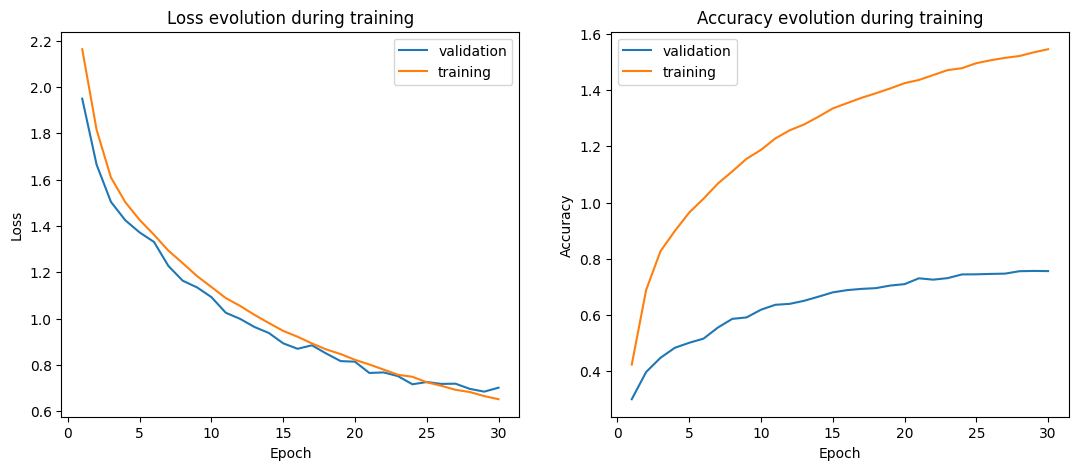

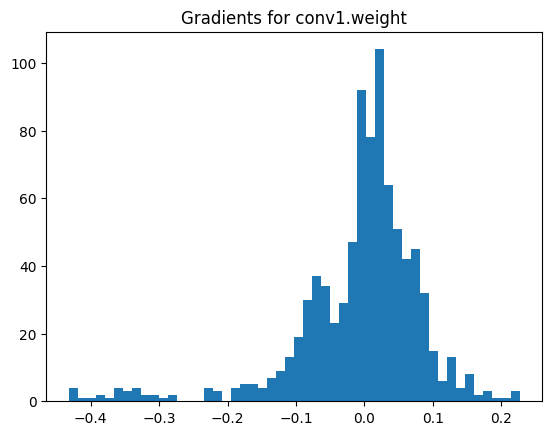

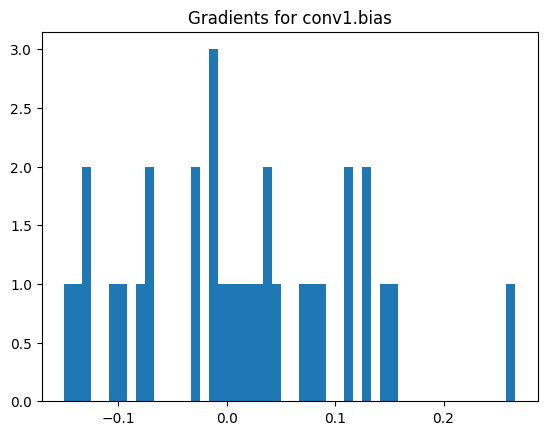

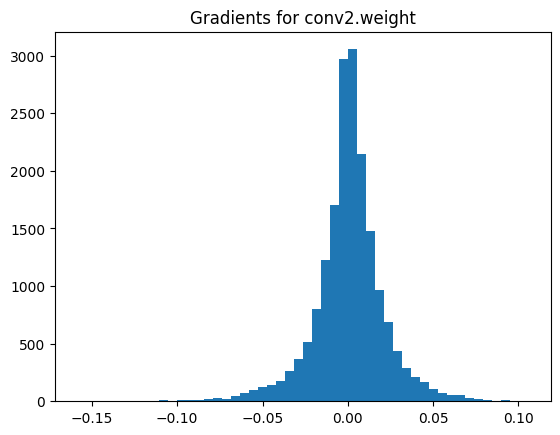

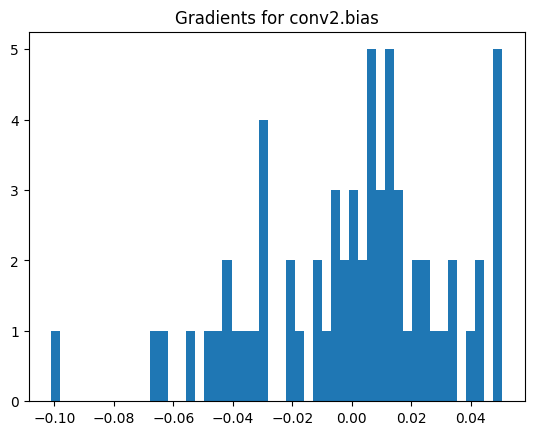

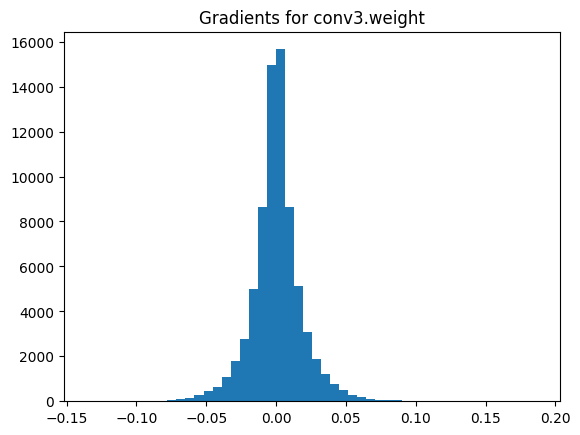

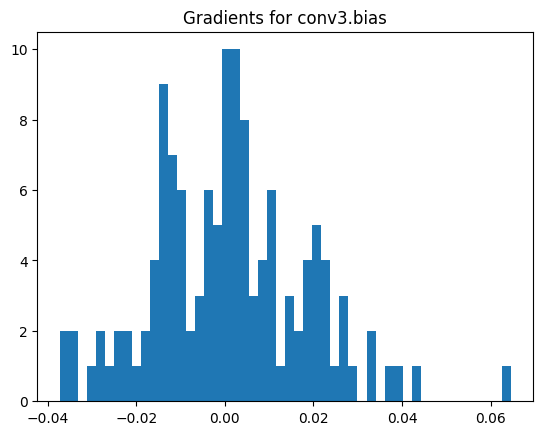

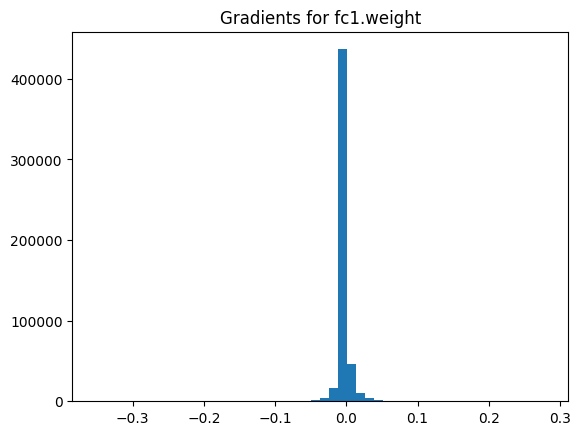

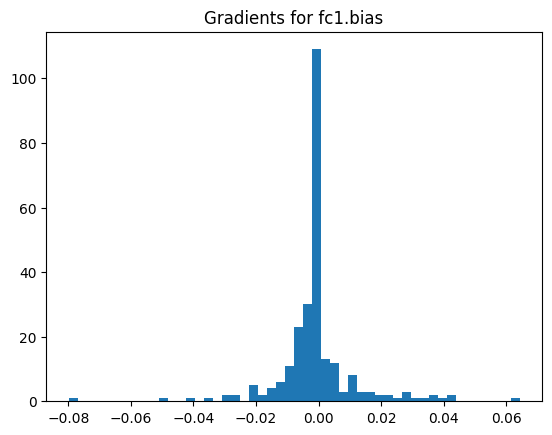

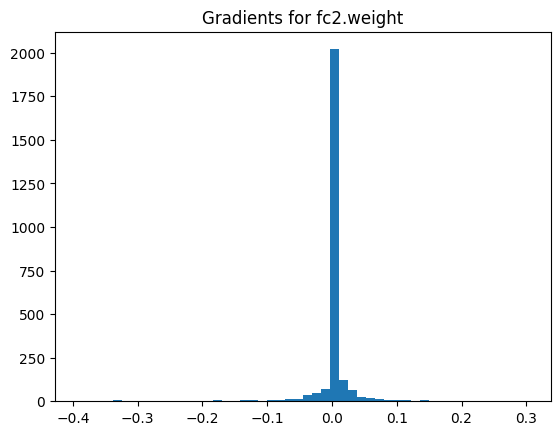

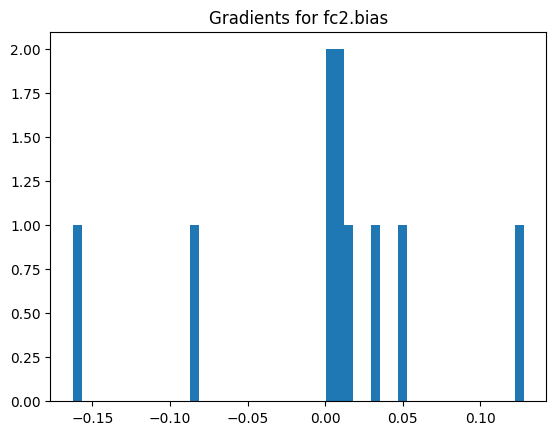

In [ ]:
# Main training parameters
model = FlatCNN()
criterion = nn.CrossEntropyLoss()
batch_size = 64
epochs = 30
lr = 0.001

# Train the model
curves = train_model(
    model,
    train_cifar10,
    val_cifar10,
    epochs,
    criterion,
    batch_size,
    lr,
)

# Visualize training curves
show_curves(curves)


# Show gradients as histograms
show_gradients(model)

In [ ]:
# Visualize training curves
show_curves(curves)

# Show feature maps using UMAP
# Assuming `features` is the feature map extracted from the model
plot_feature_maps(features)

# Show gradients as histograms
show_gradients(model)

#Resnet

In [ ]:
!pip install kornia umap-learn seaborn



In [ ]:
import os
import time
import torch
import torch.nn as nn
import torch.utils.data
import torchvision
import torchvision.transforms
import numpy as np
import matplotlib.pyplot as plt
import kornia.augmentation as K
import umap.umap_ as umap  # Importación de UMAP
from sklearn.manifold import TSNE  # Importación de t-SNE
import seaborn as sns
import random

In [ ]:
# Establecer semillas para reproducibilidad
torch.manual_seed(42)
torch.cuda.manual_seed(42)
np.random.seed(42)
random.seed(42)

In [ ]:
import torch.nn.functional as F

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, inchannel, outchannel, stride=1):
        super(ResidualBlock, self).__init__()
        self.left = nn.Sequential(
            nn.Conv2d(inchannel, outchannel, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(outchannel),
            nn.ReLU(inplace=True),
            nn.Conv2d(outchannel, outchannel, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(outchannel)
        )
        self.shortcut = nn.Sequential()
        if stride != 1 or inchannel != outchannel:
            self.shortcut = nn.Sequential(
                nn.Conv2d(inchannel, outchannel, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(outchannel)
            )

    def forward(self, x):
        out = self.left(x)
        out = out + self.shortcut(x)
        out = F.relu(out)

        return out

class ResNet(nn.Module):
    def __init__(self, ResidualBlock, num_classes=10):
        super(ResNet, self).__init__()
        self.inchannel = 64
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.layer1 = self.make_layer(ResidualBlock, 64, 2, stride=1)
        self.layer2 = self.make_layer(ResidualBlock, 128, 2, stride=2)
        self.layer3 = self.make_layer(ResidualBlock, 256, 2, stride=2)
        self.layer4 = self.make_layer(ResidualBlock, 512, 2, stride=2)
        self.fc = nn.Linear(512, num_classes)

    def make_layer(self, block, channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.inchannel, channels, stride))
            self.inchannel = channels
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [ ]:
def ResNet18_():
    return ResNet(ResidualBlock)

# Entrenamiento Resnet18

In [ ]:
def initialize_weights_he(model):
    for m in model.modules():
        if isinstance(m, nn.Conv2d):
            nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')

# Definir funciones de checkpoint y reanudar
checkpoint_dir = "/content/checkpoints/"
os.makedirs(checkpoint_dir, exist_ok=True)

def checkpoint(model, optimizer, epoch, filename):
    checkpoint_data = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }
    torch.save(checkpoint_data, os.path.join(checkpoint_dir, filename))

def resume(model, optimizer, filename):
    checkpoint_data = torch.load(os.path.join(checkpoint_dir, filename))
    model.load_state_dict(checkpoint_data['model_state_dict'])
    optimizer.load_state_dict(checkpoint_data['optimizer_state_dict'])
    return checkpoint_data['epoch']

def show_curves(curves):
    fig, ax = plt.subplots(1, 2, figsize=(13, 5))
    fig.set_facecolor('white')

    epochs = np.arange(len(curves["val_loss"])) + 1

    ax[0].plot(epochs, curves['val_loss'], label='validation')
    ax[0].plot(epochs, curves['train_loss'], label='training')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].set_title('Loss evolution during training')
    ax[0].legend()

    ax[1].plot(epochs, curves['val_acc'], label='validation')
    ax[1].plot(epochs, curves['train_acc'], label='training')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_title('Accuracy evolution during training')
    ax[1].legend()

    plt.tight_layout()
    plt.savefig('training_curves.png')
    plt.show()

def train_step(x_batch, y_batch, model, optimizer, criterion, use_gpu, augmentation, scaler):
    if augmentation:
        x_batch = augmentation(x_batch)

    optimizer.zero_grad()
    with torch.cuda.amp.autocast():
        y_predicted = model(x_batch)
        loss = criterion(y_predicted, y_batch)

    scaler.scale(loss).backward()
    scaler.step(optimizer)
    scaler.update()

    return y_predicted, loss.item()

def evaluate(val_loader, model, criterion, use_gpu):
    model.eval()
    cumulative_loss = 0
    cumulative_corrects = 0
    data_count = 0

    with torch.no_grad():
        for batch in val_loader:
            imgs, labels = batch
            if use_gpu:
                imgs = imgs.cuda()
                labels = labels.cuda()

            final_output = model(imgs)

            loss = criterion(final_output, labels)
            cumulative_loss += loss.item() * len(labels)
            data_count += len(labels)

            _, pred_class = final_output.max(1)
            cumulative_corrects += (pred_class == labels).sum().item()

        val_acc = cumulative_corrects / data_count
        val_loss = cumulative_loss / data_count

    return val_acc, val_loss

def train_model(
    model,
    train_dataset,
    val_dataset,
    epochs,
    max_iterations,
    criterion,
    batch_size,
    lr,
    n_evaluations_per_epoch,
    use_gpu=True,
    data_augmentation=False,
    resume_checkpoint=None
):
    original_transform = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(
            (0.4914, 0.4822, 0.4465),
            (0.247, 0.243, 0.261)
        ),
    ])

    if data_augmentation:
        # Solo normalización en el dataset
        train_dataset.dataset.transform = original_transform
        if use_gpu:
            augmentation = torch.nn.Sequential(
                K.RandomHorizontalFlip(p=0.5),
                K.ColorJitter(
                    brightness=0.2,
                    contrast=0.2,
                    saturation=0.2,
                    hue=0.1
                )
            ).cuda()
        else:
            augmentation = None
    else:
        train_dataset.dataset.transform = original_transform
        augmentation = None

    print(f"Using train transform: {train_dataset.dataset.transform}")
    print(f"Using validation transform: {val_dataset.dataset.transform}")

    if use_gpu:
        model.cuda()

    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=use_gpu
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=100, shuffle=False,num_workers=2, pin_memory=use_gpu
    )

    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=0.0001)

    scaler = torch.cuda.amp.GradScaler()

    curves = {
        "train_acc": [],
        "val_acc": [],
        "train_loss": [],
        "val_loss": [],
    }

    t0 = time.perf_counter()

    iteration = 0

    n_batches = len(train_loader)

    start_epoch = 0
    if resume_checkpoint is not None:
        start_epoch = resume(model, optimizer, resume_checkpoint)
        print(f"Reanudando desde la época {start_epoch}")

    best_val_loss = float('inf')

    for epoch in range(start_epoch, epochs):
        print(f"\rEpoch {epoch + 1}/{epochs}")
        cumulative_train_loss = 0
        cumulative_train_corrects = 0
        train_loss_count = 0
        train_acc_count = 0

        model.train()
        for i, (x_batch, y_batch) in enumerate(train_loader):
            if use_gpu:
                x_batch = x_batch.cuda(non_blocking=True)
                y_batch = y_batch.cuda(non_blocking=True)

            y_predicted, loss = train_step(
                x_batch, y_batch, model, optimizer, criterion, use_gpu, augmentation, scaler
            )

            cumulative_train_loss += loss
            train_loss_count += 1
            train_acc_count += y_batch.shape[0]

            class_prediction = torch.argmax(y_predicted, axis=1).long()
            cumulative_train_corrects += (y_batch == class_prediction).sum().item()

            if (i % (n_batches // n_evaluations_per_epoch) == 0) and (i > 0):
                train_loss = cumulative_train_loss / train_loss_count
                train_acc = cumulative_train_corrects / train_acc_count

                print(
                    f"Iteration {iteration} - Batch {i}/{len(train_loader)} - "
                    f"Train loss: {train_loss:.4f}, Train acc: {train_acc:.4f}"
                )

            iteration += 1

            if iteration >= max_iterations:
                print(f"Máximo número de iteraciones alcanzado: {max_iterations}")
                return curves

        val_acc, val_loss = evaluate(val_loader, model, criterion, use_gpu)

        print(f"Val loss: {val_loss:.4f}, Val acc: {val_acc:.4f}")

        train_loss = cumulative_train_loss / train_loss_count
        train_acc = cumulative_train_corrects / train_acc_count
        curves["train_acc"].append(train_acc)
        curves["val_acc"].append(val_acc)
        curves["train_loss"].append(train_loss)
        curves["val_loss"].append(val_loss)


        # Guardar el mejor modelo
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            checkpoint(model, optimizer, epoch, f"best_checkpoint_epoch_{epoch}.pth")
            print(f"Checkpoint guardado en la época {epoch}")

    print()
    print(f"Tiempo total de entrenamiento: {time.perf_counter() - t0:.4f} [s]")

    model.cpu()

    if data_augmentation:
        train_dataset.dataset.transform = original_transform

    return curves

#Entrenamiento y datasets

In [ ]:
# Definir el modelo y los parámetros de entrenamiento
model = ResNet18_()
initialize_weights_he(model)
criterion = nn.CrossEntropyLoss()
batch_size = 128
epochs = 30
max_iterations = 600000
lr = 0.1
use_gpu = torch.cuda.is_available()




In [ ]:
# Descargar y preparar los datasets
full_cifar10 = torchvision.datasets.CIFAR10(
    root="./cifar10",
    train=True,
    download=True,
)

train_transform = torchvision.transforms.Compose([
    torchvision.transforms.RandomCrop(32, padding=4, padding_mode='reflect'),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(
        (0.4914, 0.4822, 0.4465),
        (0.247, 0.243, 0.261)
    ),
])

val_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(
        (0.4914, 0.4822, 0.4465),
        (0.247, 0.243, 0.261)
    ),
])

train_cifar10 = torchvision.datasets.CIFAR10(
    root="./cifar10",
    train=True,
    download=False,
    transform=train_transform
)

val_cifar10 = torchvision.datasets.CIFAR10(
    root="./cifar10",
    train=True,
    download=False,
    transform=val_transform
)

train_cifar10, _ = torch.utils.data.random_split(
    train_cifar10, [45000, 5000], generator=torch.Generator().manual_seed(42)
)
_, val_cifar10 = torch.utils.data.random_split(
    val_cifar10, [45000, 5000], generator=torch.Generator().manual_seed(42)
)


Files already downloaded and verified


Using train transform: Compose(
    ToTensor()
    Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.243, 0.261))
)
Using validation transform: Compose(
    ToTensor()
    Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.243, 0.261))
)
Epoch 1/30


<ipython-input-18-ae2d23cf51a5>:146: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
<ipython-input-18-ae2d23cf51a5>:53: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Iteration 17 - Batch 17/352 - Train loss: 4.5669, Train acc: 0.1098
Iteration 34 - Batch 34/352 - Train loss: 3.4943, Train acc: 0.1243
Iteration 51 - Batch 51/352 - Train loss: 3.0293, Train acc: 0.1508
Iteration 68 - Batch 68/352 - Train loss: 2.7811, Train acc: 0.1663
Iteration 85 - Batch 85/352 - Train loss: 2.6239, Train acc: 0.1799
Iteration 102 - Batch 102/352 - Train loss: 2.5043, Train acc: 0.1958
Iteration 119 - Batch 119/352 - Train loss: 2.4109, Train acc: 0.2107
Iteration 136 - Batch 136/352 - Train loss: 2.3297, Train acc: 0.2246
Iteration 153 - Batch 153/352 - Train loss: 2.2661, Train acc: 0.2393
Iteration 170 - Batch 170/352 - Train loss: 2.2121, Train acc: 0.2511
Iteration 187 - Batch 187/352 - Train loss: 2.1649, Train acc: 0.2615
Iteration 204 - Batch 204/352 - Train loss: 2.1233, Train acc: 0.2713
Iteration 221 - Batch 221/352 - Train loss: 2.0851, Train acc: 0.2803
Iteration 238 - Batch 238/352 - Train loss: 2.0516, Train acc: 0.2889
Iteration 255 - Batch 255/352 

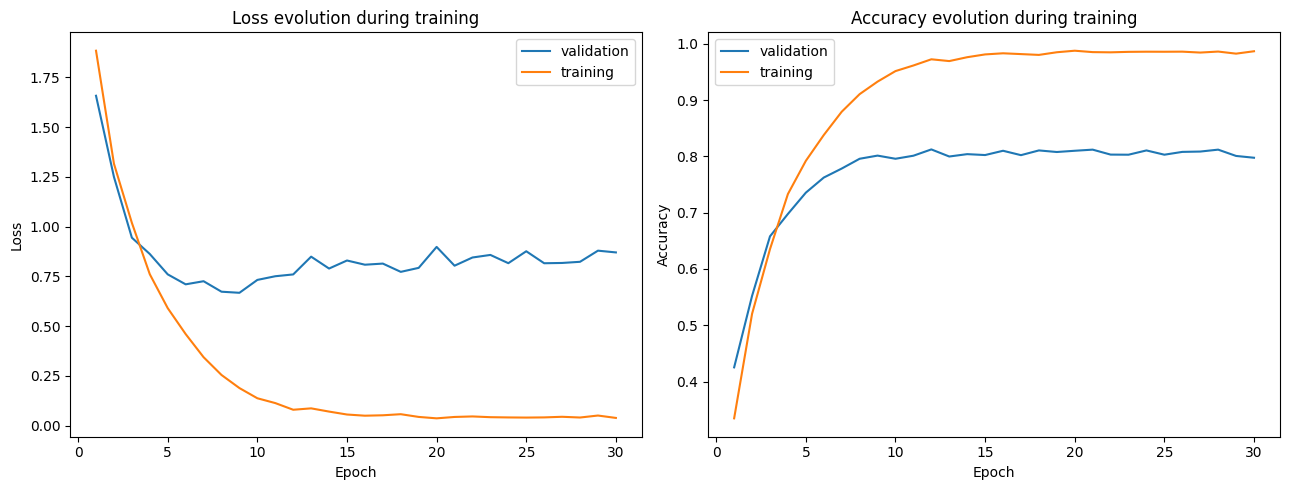

In [ ]:
# Entrenar el modelo
curves = train_model(
    model=model,
    train_dataset=train_cifar10,
    val_dataset=val_cifar10,
    epochs=epochs,
    max_iterations=max_iterations,
    criterion=criterion,
    batch_size=batch_size,
    lr=lr,
    n_evaluations_per_epoch=20,
    use_gpu=use_gpu,
    data_augmentation=False,
)

show_curves(curves)

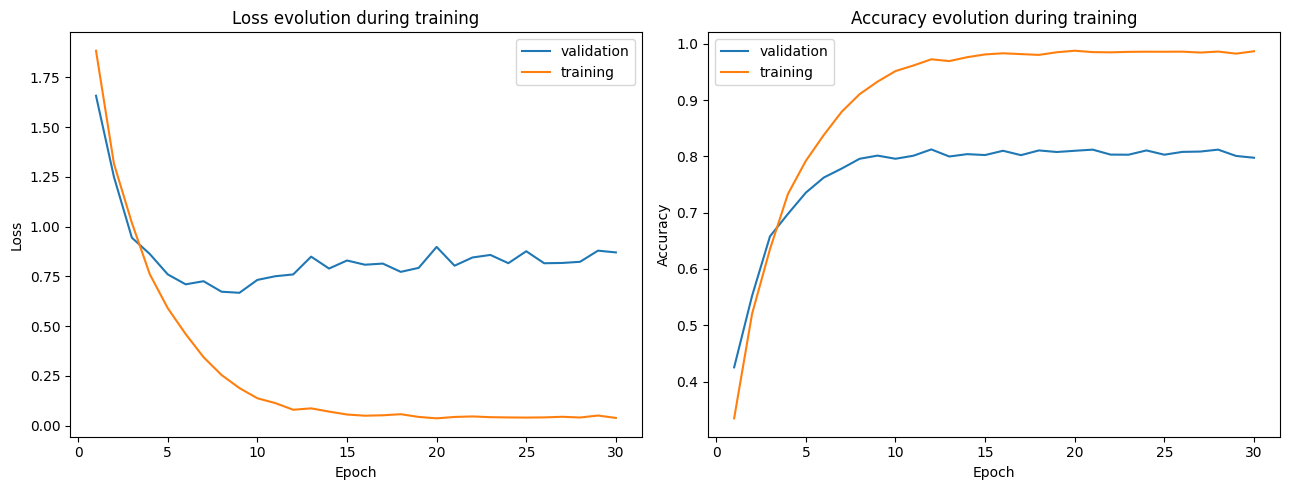

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


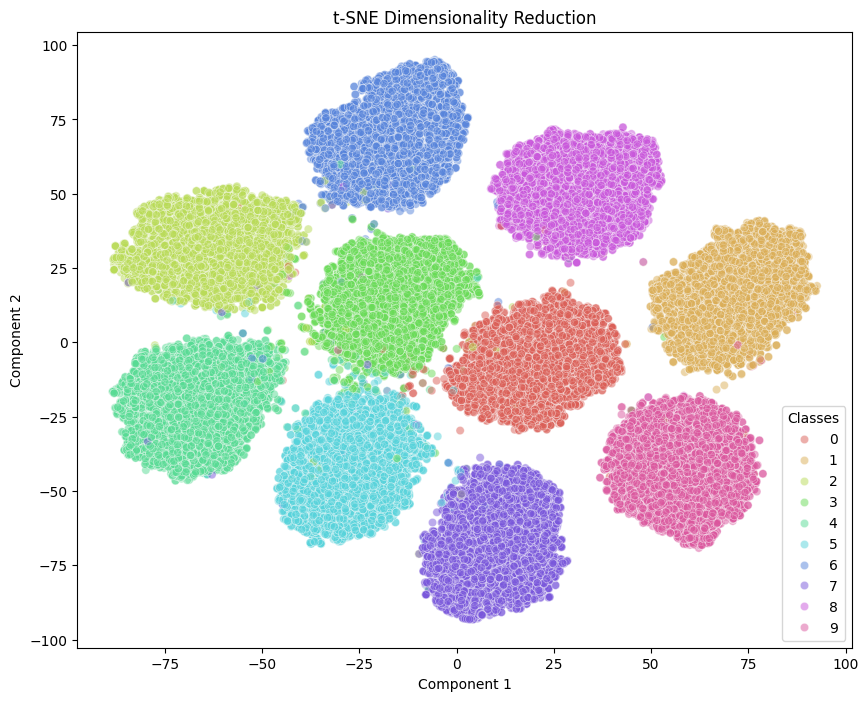

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


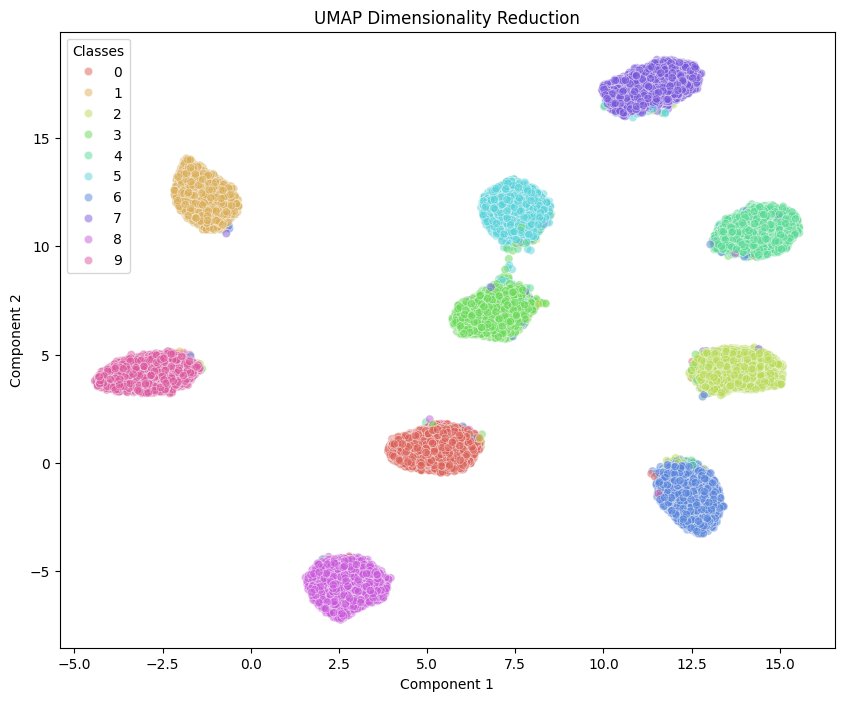

In [ ]:
# Mover el modelo a la GPU si es necesario
if use_gpu:
    model.cuda()

# Obtener embeddings y realizar visualizaciones
def get_embeddings(model, dataloader, use_gpu):
    model.eval()
    embeddings = []
    labels = []

    with torch.no_grad():
        for imgs, lbls in dataloader:
            if use_gpu:
                imgs = imgs.cuda()
            # Process the images through the model layers
            features = model.conv1(imgs)
            features = model.layer1(features)
            features = model.layer2(features)
            features = model.layer3(features)
            features = model.layer4(features)
            # Perform average pooling directly
            features = F.avg_pool2d(features, 4)
            features = torch.flatten(features, 1)
            embeddings.append(features.cpu())
            labels.append(lbls)

    embeddings = torch.cat(embeddings)
    labels = torch.cat(labels)
    return embeddings, labels

# Crear un dataloader para todo el conjunto de entrenamiento
full_train_loader = torch.utils.data.DataLoader(
    train_cifar10, batch_size=256, shuffle=False, num_workers=12, pin_memory=use_gpu
)

# Obtener las embeddings
embeddings, labels = get_embeddings(model, full_train_loader, use_gpu)
# Convertir embeddings y labels a NumPy arrays
embeddings_np = embeddings.numpy()
labels_np = labels.numpy()

# Visualización con t-SNE (Scikit-learn)
from sklearn.manifold import TSNE

# Configurar t-SNE
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)

# Ajustar y transformar las embeddings
embeddings_tsne = tsne.fit_transform(embeddings_np)

# Graficar
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=embeddings_tsne[:, 0], y=embeddings_tsne[:, 1],
    hue=labels_np, palette=sns.color_palette("hls", 10),
    legend="full", alpha=0.5
)
plt.title('t-SNE Dimensionality Reduction')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend(title='Classes')
plt.show()

# Visualización con UMAP
import umap.umap_ as umap

# Configurar UMAP
umap_reducer = umap.UMAP(
    n_neighbors=15,
    min_dist=0.1,
    n_components=2,
    metric='euclidean',
    random_state=42
)

# Ajustar y transformar las embeddings
embeddings_umap = umap_reducer.fit_transform(embeddings_np)

# Graficar
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=embeddings_umap[:, 0], y=embeddings_umap[:, 1],
    hue=labels_np, palette=sns.color_palette("hls", 10),
    legend="full", alpha=0.5
)
plt.title('UMAP Dimensionality Reduction')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend(title='Classes')
plt.show()

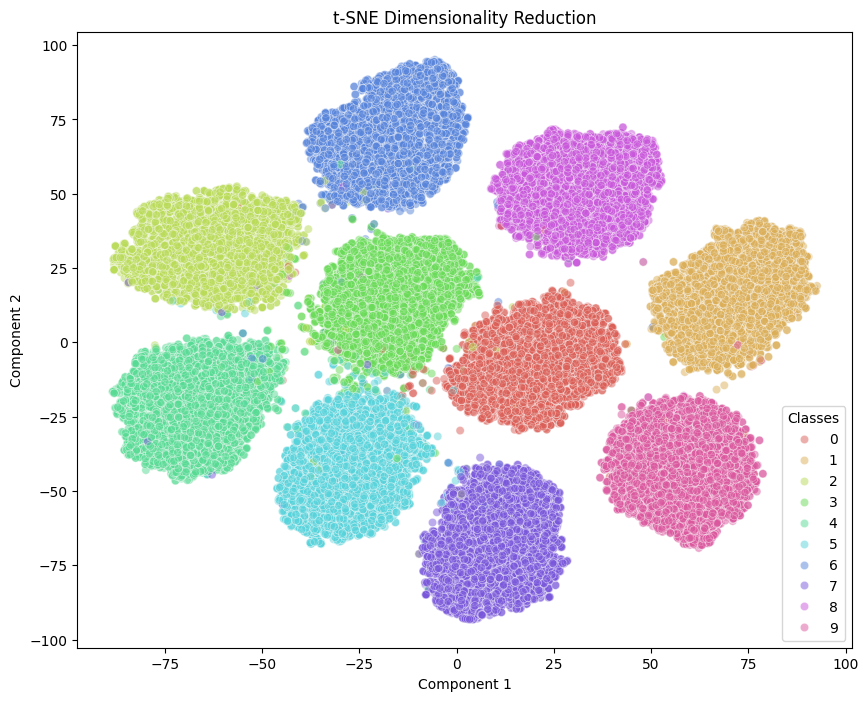

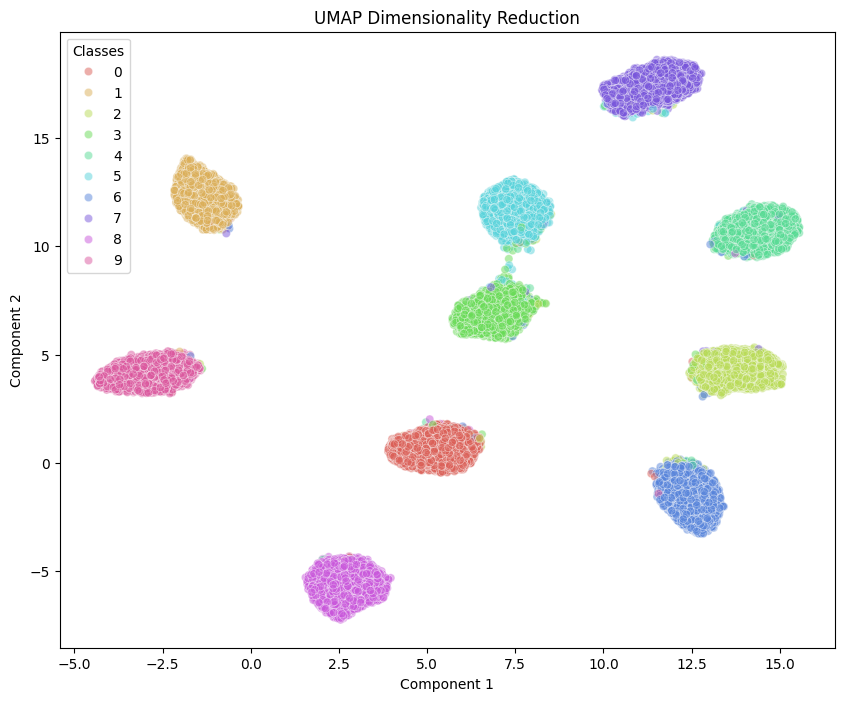